In [1]:
import torch
torch.cuda.empty_cache()
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.transforms import transforms
from torchsummary import summary
import matplotlib.pyplot as plt

from helper_data import get_dataloaders_cifar10
from helper_train import train_cifar10_classifier, eval_cifar10_classifier, metric_accuracy

In [2]:
# global settings
torch.manual_seed(0)

LEARNING_RATE = 0.001
BATCH_SIZE = 128
VALIDATION_SIZE = 0.2

NUM_CLASSES = 10
NUM_EPOCHS = 40

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# class labels
classes = ['plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [3]:
# get dataloaders
transfrom = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.25, 0.25, 0.25)),
])

train_loader, test_loader = get_dataloaders_cifar10(batch_size=BATCH_SIZE, train_transforms=transfrom, test_transforms=transfrom)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
# check data dimensions
train_iter = iter(train_loader)

image_batch, labels_batch = next(train_iter)

print(f"Image batch dimensions: {image_batch.size()}")
print(f"Labels batch dimensions: {labels_batch.size()}")

Image batch dimensions: torch.Size([128, 3, 32, 32])
Labels batch dimensions: torch.Size([128])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0..2.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9215686..1.9843137].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6862745..2.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9372549..1.6705883].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0..1.9843137].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0..1.9529412].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8901961..1.9058824].
Clipping input 

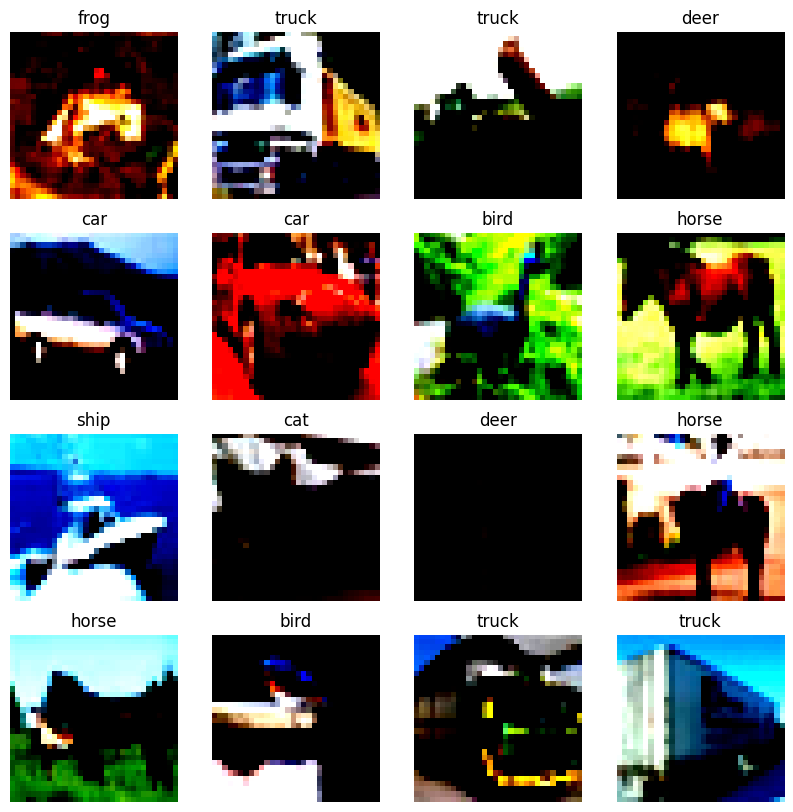

In [5]:
# plot dataset examples
for images, labels in train_loader:
    images_to_plot = images[0:16]
    labels_to_plot = labels[0:16]
    break

fig, ax = plt.subplots(4, 4, figsize=(10,10))
ax = ax.ravel()

for i in range(16):
    ax[i].imshow(images_to_plot[i].permute(1, 2, 0))
    ax[i].set_axis_off()
    ax[i].title.set_text(classes[labels_to_plot[i].item()])

In [6]:
class VGG16(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_set1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        # shape after 64x112x112
        self.conv_set2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        # shape after 128x56x56
        self.conv_set3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        # shape after 256x28x28
        self.conv_set4 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        # shape after 512x14x14
        self.conv_set5 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        # shape after 512x7x7
        self.linear_set1 = nn.Sequential(
            nn.Linear(in_features=512*1*1, out_features=4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5)
        )
        self.linear_set2 = nn.Sequential(
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(),
            nn.Dropout(p=0.5)
        )
        self.linear_set3 = nn.Linear(in_features=4096, out_features=10)

    def forward(self, x):
        x = self.conv_set1(x)
        x = self.conv_set2(x)
        x = self.conv_set3(x)
        x = self.conv_set4(x)
        x = self.conv_set5(x)
        x = torch.flatten(x, 1)
        x = self.linear_set1(x)
        x = self.linear_set2(x)
        x = self.linear_set3(x)

        return x


In [7]:
# set optimizer and loss
vgg16_net = VGG16()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg16_net.parameters(), lr=LEARNING_RATE)

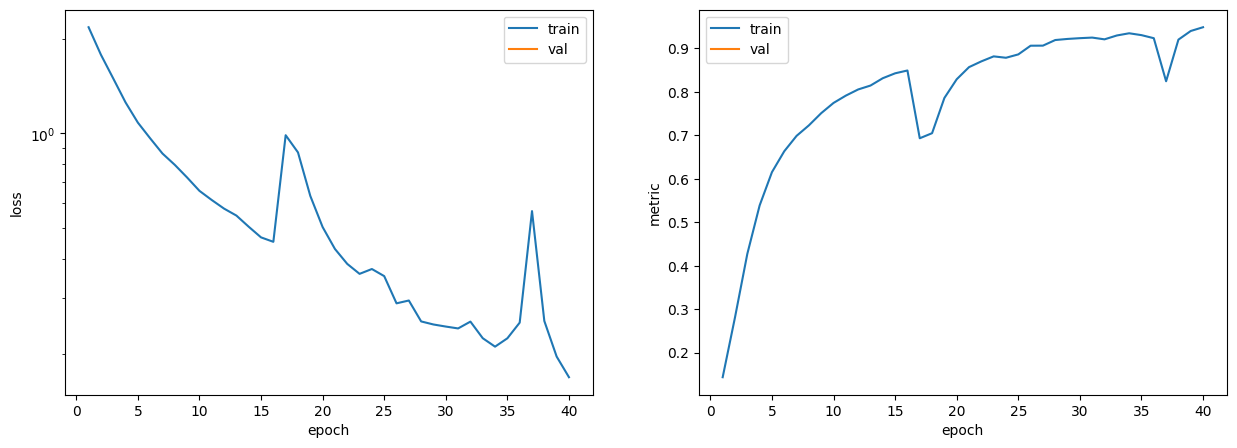

In [8]:
# train model
train_metrics, val_metrics = train_cifar10_classifier(
    model = vgg16_net,
    optimizer = optimizer,
    criterion = criterion,
    accuracy = metric_accuracy,
    train_loader = train_loader,
    val_loader = None,
    num_epochs = NUM_EPOCHS,
    device = DEVICE
)

In [9]:
vgg16_net = eval_cifar10_classifier(vgg16_net, test_loader, classes, device=DEVICE)

Total accuracy: 75.76 %
Accuracy for class: plane is 80.5 %
Accuracy for class: car   is 83.2 %
Accuracy for class: bird  is 60.0 %
Accuracy for class: cat   is 60.1 %
Accuracy for class: deer  is 63.2 %
Accuracy for class: dog   is 73.1 %
Accuracy for class: frog  is 89.0 %
Accuracy for class: horse is 73.8 %
Accuracy for class: ship  is 89.9 %
Accuracy for class: truck is 84.9 %
